# Implementing and testing the Larkin transform
---

In [1]:
import sys
import os

dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm

In [3]:
from lib.FT_modelling import *
from lib.formatter import * 
from lib.conversions import *
from lib.photometry import *

In [4]:
pupil = pupil_from_fits("pupil.fits")

In [5]:
# Define simulation parameters

aperture = 0.018 # 18mm
m2_obsc = 0 # m
wl = 525e-9 # 525nm - Central green band on RBP cam
fl = 0.15 # 15cm camera lens
npix = 512 # Only simulate central region
pix_size = 1.12e-6 # 1.12 microns
tf_size = 2**10 # 1024
x = 0 # On-axis star (pixel units)
y = 0 # On-axis star (pixel units)

In [6]:
# Create a model m, PSF on a grid twice the size of the data image
m = FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, tf_size, x, y)

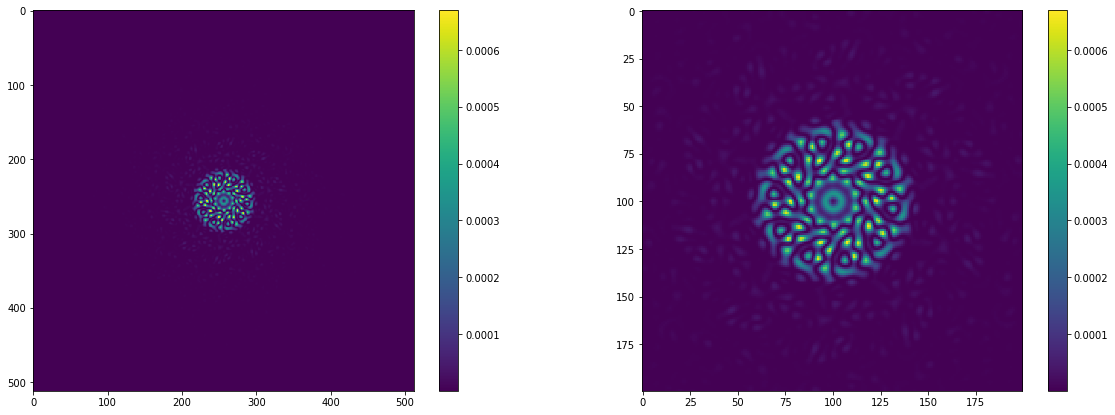

In [7]:
s = 100
c = npix//2
plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.imshow(m)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(m[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

In [8]:
auto_c = larkin_transform(m, m)

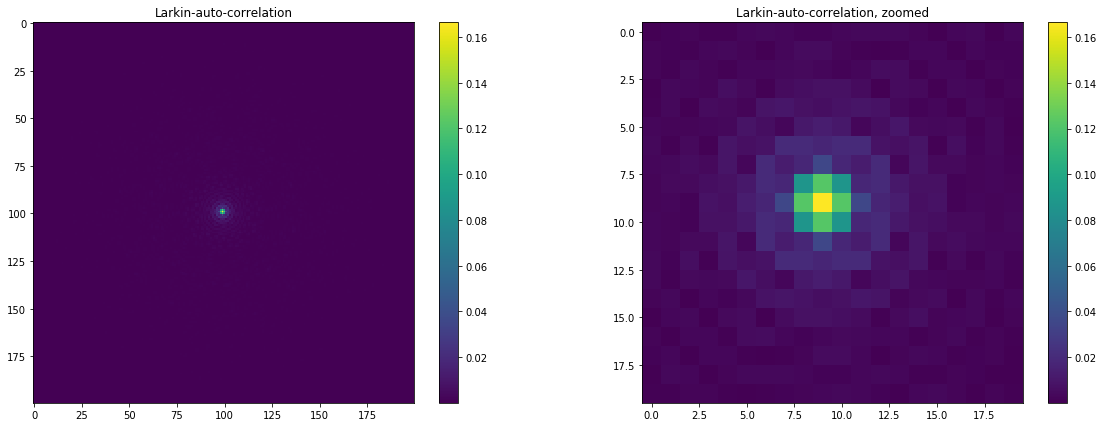

In [9]:
plt.figure(figsize=(20,7))
s2 = 10

plt.subplot(1,2,1)
plt.title("Larkin-auto-correlation")
plt.imshow(auto_c[c-s:c+s, c-s:c+s])
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Larkin-auto-correlation, zoomed")
plt.imshow(auto_c[c-s2:c+s2, c-s2:c+s2])
plt.colorbar()
plt.show()

---
### Get the flux-correlation value relationship

The flux correlation value relationship is linear and is demonstrated to be so in the CLEAN.ipynb doccument

In [11]:
S = 1/np.max(auto_c)
print(S)

6.007315233238523


---
## Simulate single star, on-axis, no detector or photon noise

In [12]:
# Define image paramters

n_stars = 1
fluxes_in = [1e6]
coords_in = np.array([[0, 0]])
# coords_in = np.array([[-npix//2, -npix//2]])
# coords_in = np.array([[20, 20]]) # returns x-1, y+1
# coords_in = np.array([[-20, -20]]) # returns x-1, y+1
# coords_in = np.array([[20, -20]]) # returns x-1, y+1
# coords_in = np.array([[-20, 20]]) # returns x-1, y+1

In [13]:
data = np.zeros([npix, npix])
for i in range(n_stars):
    data += fluxes_in[i]*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, coords_in[i, 0], coords_in[i, 1], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(data)

In [14]:
# Get correlation peaks
C = larkin_transform(im, m)
pos, peak = get_max(C)
print(pos, peak)

[-1  1] 1.6646371318538348e-07


Note how the larkin trasnform has some constant shift value, with each returned value being shifted by -1 pixel in x and +1 in y

---
## Simulate multiple randomised stars shifted by integer values, no detector or photon noise, all equal flux, no PSFs over the edge

In [15]:
# Define image paramters

n_stars = 6
fluxes_in = 1e6 * np.ones(n_stars)
# coords_in = np.array([[-npix//2, -npix//2], [-npix//2, -npix//2]])

# Seed for reproducibility
np.random.seed(0)

# Shift the coordianted by this amount ot prevent the PSFs going over the edge of the detector
edge_oset = 60
t_range = npix - 2*edge_oset # total range
p_range = [-t_range//2, t_range//2]# range of positions values
coords_in = np.random.randint(p_range[0], p_range[1], size=[n_stars, 2])

print(coords_in)

[[ -24 -149]
 [ -79   -4]
 [ 127   55]
 [  -1  163]
 [-187   15]
 [  81   46]]


In [16]:
data = np.zeros([npix, npix])
for i in range(n_stars):
    data += fluxes_in[i]*FT_model(pupil, aperture, m2_obsc, npix, wl, fl, pix_size, 
                                  tf_size, coords_in[i, 0], coords_in[i, 1], polar=False)
# Keep a copy of the original data point so we can work on the "im" variable
im = deepcopy(data)

In [18]:
C = larkin_transform(im, m)
p1, peak1 = get_max(C)

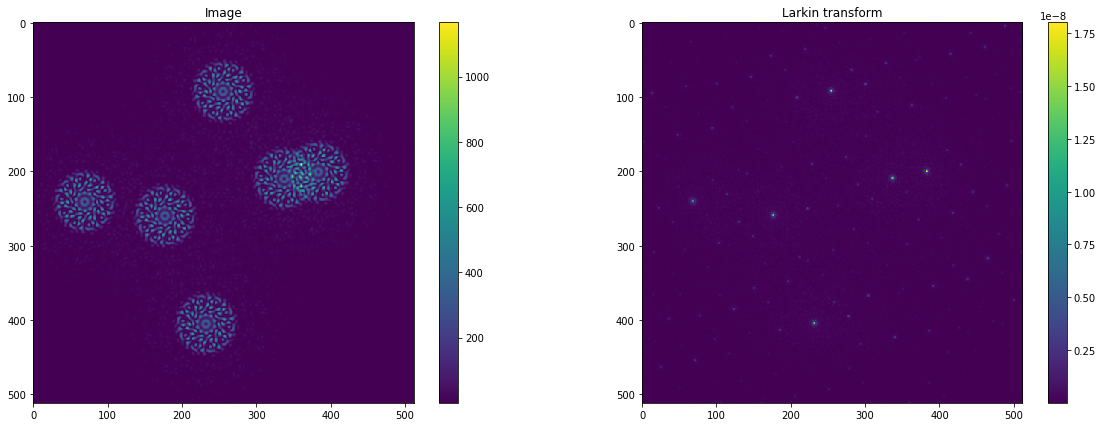

In [19]:
plt.figure(figsize=(20,7))

plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(im)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Larkin transform")
plt.imshow(C)
plt.colorbar()

plt.show()